In this notebook, we propose a demonstartion of GLUE embedding. We apply our implementation as well as the original code on the bulk data of Alzheimer's disease.

# GLUE

## Setting up data

In [1]:
import omicverse as ov
ov.utils.ov_plot_set()

2023-05-18 10:31:01.383243: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 10:31:01.461336: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-18 10:31:01.461353: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-18 10:31:01.972279: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

/mnt/data/env/pyomic/lib/python3.8/site-packages/phate/__init__.py


In [2]:
rna=ov.utils.read('single_adata_ad.h5ad')
rna

AnnData object with n_obs × n_vars = 61472 × 58721
    obs: 'SampleID', 'Diagnosis', 'Batch', 'Cell.Type', 'cluster', 'Age', 'Sex', 'PMI', 'Tangle.Stage', 'Plaque.Stage', 'RIN'
    var: 'gene_ids', 'feature_types', 'genome'

The `GSE174367_snATAC-seq_filtered_peak_bc_matrix.h5` and `GSE174367_snATAC-seq_cell_meta.csv.gz` can be downloaded from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE174367

In [14]:
import scanpy as sc
atac=sc.read_10x_h5('GSE174367_snATAC-seq_filtered_peak_bc_matrix.h5',gex_only=False)
atac.obs.index.name, atac.var.index.name = "cells", "peaks"

reading GSE174367_snATAC-seq_filtered_peak_bc_matrix.h5
 (0:00:05)


In [15]:
import numpy as np
atac.var["chrom"] = np.vectorize(lambda x: x.split(":")[0])(atac.var["gene_ids"])
atac.var["chromStart"] = np.vectorize(lambda x: int(x.split(":")[1].split("-")[0]))(atac.var["gene_ids"])
atac.var["chromEnd"] = np.vectorize(lambda x: int(x.split("-")[1]))(atac.var["gene_ids"])
atac.var.head()

,gene_ids,feature_types,genome,chrom,chromStart,chromEnd
peaks,,,,,,
chr1:190849-191920,chr1:190849-191920,Peaks,GRCh38,chr1,190849,191920
chr1:629708-630559,chr1:629708-630559,Peaks,GRCh38,chr1,629708,630559
chr1:631640-631948,chr1:631640-631948,Peaks,GRCh38,chr1,631640,631948
chr1:632511-633105,chr1:632511-633105,Peaks,GRCh38,chr1,632511,633105
chr1:633740-634682,chr1:633740-634682,Peaks,GRCh38,chr1,633740,634682


In [16]:
import pandas as pd
meta1=pd.read_csv('GSE174367_snATAC-seq_cell_meta.csv.gz',index_col=11)
meta1.head()

,Sample.ID,Batch,Age,Sex,PMI,Tangle.Stage,Plaque.Stage,Diagnosis,RIN,cluster,Cell.Type
Barcode,,,,,,,,,,,
AAACGAAAGAAACGCC-13,Sample-96,1,79,M,7.00,Stage 1,Stage A,Control,7.1,ODC.f,ODC
AAACGAAAGAAATGGG-11,Sample-101,2,74,F,7.75,Stage 2,Stage B,Control,8.1,ODC.k,ODC
AAACGAAAGAAATGGG-5,Sample-37,3,87,F,4.25,Stage 6,Stage C,AD,7.0,PER.END.a,PER.END
AAACGAAAGAAATTCG-13,Sample-96,1,79,M,7.00,Stage 1,Stage A,Control,7.1,EX.b,EX
AAACGAAAGAACGACC-8,Sample-43,1,90,F,4.17,Stage 6,Stage B,AD,8.9,ODC.a,ODC


In [17]:
ret_obs=list(set(atac.obs.index) & set(meta1.index))
len(ret_obs)

130418

In [18]:
atac=atac[ret_obs]
atac.obs=meta1.loc[ret_obs]
atac

AnnData object with n_obs × n_vars = 130418 × 219070
    obs: 'Sample.ID', 'Batch', 'Age', 'Sex', 'PMI', 'Tangle.Stage', 'Plaque.Stage', 'Diagnosis', 'RIN', 'cluster', 'Cell.Type'
    var: 'gene_ids', 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd'

In [31]:
del atacdata

In [21]:
atac.obs=atac.obs.astype({"Batch": int, "Cell.Type": 'category',
                     "Sample.ID": 'category',
                     "Age":int,
                     "Sex": 'category',
                     "PMI":float,
                     "RIN":float,
                     "Tangle.Stage": 'category',
                     "Plaque.Stage": 'category',
                     "Diagnosis": 'category',})

In [22]:
atac.write_h5ad("GSE174367_atac.h5ad", compression="gzip")


In [23]:
rna.layers["counts"] = rna.X.copy()

In [24]:
sc.pp.highly_variable_genes(rna, n_top_genes=4000, flavor="seurat_v3")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [25]:
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.scale(rna)
sc.tl.pca(rna, n_comps=100, svd_solver="auto")

normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    on highly variable genes
    with n_comps=100
    finished (0:00:10)


computing neighbors
    using 'X_pca' with n_pcs = 100
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:02)


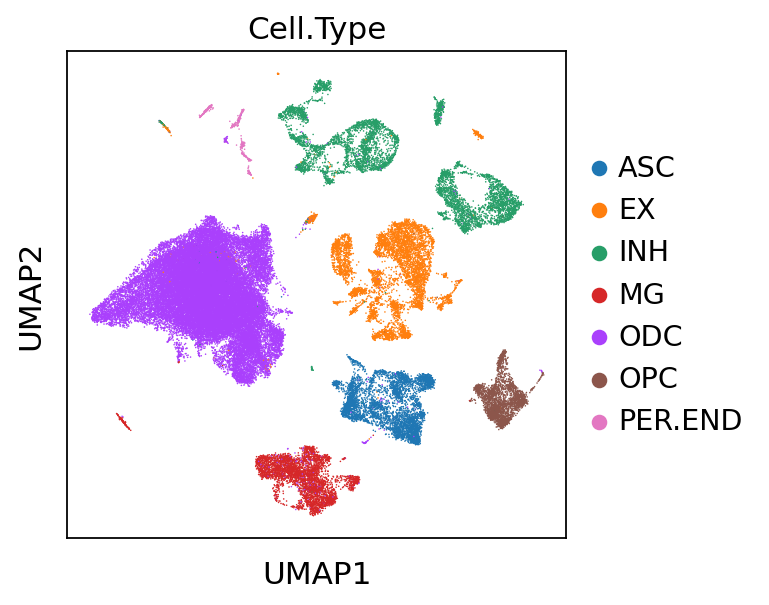

In [26]:
sc.pp.neighbors(rna, metric="cosine")
sc.tl.umap(rna)
sc.pl.umap(rna, color="Cell.Type")

In [28]:
import scglue
scglue.data.lsi(atac, n_components=100, n_iter=15)

In [29]:
sc.pp.neighbors(atac, use_rep="X_lsi", metric="cosine")
sc.tl.umap(atac)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:10)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:51)


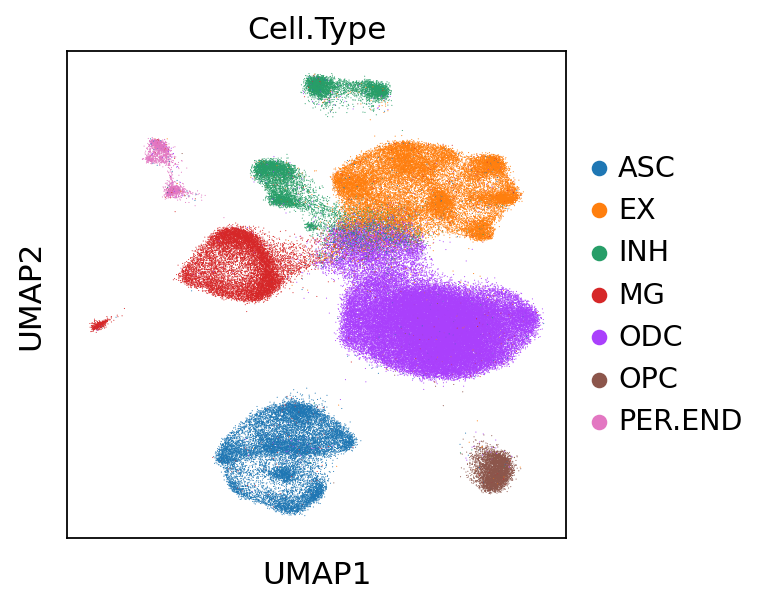

In [30]:
sc.pl.umap(atac, color="Cell.Type")

In [ ]:
atac.write_h5ad("GSE174367_atac.h5ad", compression="gzip")


In [32]:
scglue.data.get_gene_annotation(
    rna, gtf="/mnt/home/zehuazeng/data/gtf/gencode.v43.basic.annotation.gtf.gz",
    gtf_by="gene_name"
)
rna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()

,chrom,chromStart,chromEnd
DDX11L1,chr1,12009.0,13670.0
WASH7P,chr1,14403.0,29570.0
MIR6859-1,chr1,17368.0,17436.0
MIR1302-2HG,chr1,29553.0,31109.0
MIR1302-2,chr1,30365.0,30503.0


In [34]:
split = atac.var_names.str.split(r"[:-]")
atac.var["chrom"] = split.map(lambda x: x[0])
atac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
atac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
atac.var.head()

,gene_ids,feature_types,genome,chrom,chromStart,chromEnd
peaks,,,,,,
chr1:190849-191920,chr1:190849-191920,Peaks,GRCh38,chr1,190849,191920
chr1:629708-630559,chr1:629708-630559,Peaks,GRCh38,chr1,629708,630559
chr1:631640-631948,chr1:631640-631948,Peaks,GRCh38,chr1,631640,631948
chr1:632511-633105,chr1:632511-633105,Peaks,GRCh38,chr1,632511,633105
chr1:633740-634682,chr1:633740-634682,Peaks,GRCh38,chr1,633740,634682


In [37]:
rna=rna[:,~rna.var['chromStart'].isnull()]
del rna.var['artif_dupl']
del rna.var['tag']
del rna.var['havana_gene']
del rna.var['itemRgb']

In [38]:
rna.var["chromStart"] = rna.var["chromStart"].astype(int)
rna.var["chromEnd"] = rna.var["chromEnd"].astype(int)

In [40]:
rna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()

,chrom,chromStart,chromEnd
DDX11L1,chr1,12009,13670
WASH7P,chr1,14403,29570
MIR6859-1,chr1,17368,17436
MIR1302-2HG,chr1,29553,31109
MIR1302-2,chr1,30365,30503


In [41]:
guidance = scglue.genomics.rna_anchored_guidance_graph(rna, atac)
guidance

window_graph:   0%|          | 0/36643 [00:00<?, ?it/s]

In [42]:
scglue.graph.check_graph(guidance, [rna, atac])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [43]:
atac.var.head()

,gene_ids,feature_types,genome,chrom,chromStart,chromEnd,highly_variable
peaks,,,,,,,
chr1:190849-191920,chr1:190849-191920,Peaks,GRCh38,chr1,190849,191920,False
chr1:629708-630559,chr1:629708-630559,Peaks,GRCh38,chr1,629708,630559,False
chr1:631640-631948,chr1:631640-631948,Peaks,GRCh38,chr1,631640,631948,False
chr1:632511-633105,chr1:632511-633105,Peaks,GRCh38,chr1,632511,633105,False
chr1:633740-634682,chr1:633740-634682,Peaks,GRCh38,chr1,633740,634682,False


In [47]:
del rna.var['artif_dupl']
del rna.var['tag']
del rna.var['havana_gene']
del rna.var['itemRgb']

In [46]:
rna.var.columns

Index(['gene_ids', 'feature_types', 'genome', 'highly_variable',
       'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean',
       'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand',
       'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes',
       'blockStarts', 'gene_id', 'gene_type', 'tag', 'hgnc_id', 'havana_gene',
       'artif_dupl'],
      dtype='object')

In [48]:
rna.write("rna-pp.h5ad", compression="gzip")
atac.write("atac-pp.h5ad", compression="gzip")


In [49]:
import networkx as nx
nx.write_graphml(guidance, "guidance.graphml.gz")